### New Subscriber Acqusitions:

 Acquiring new subscribers is vital for telecom carriers to boost revenue, increase market share, and enhance brand visibility. It compensates for customer churn and fuels investments in network and technological advancements, ensuring competitive strength in a fast-evolving industry.

 Understanding subscriber behaviors and their propensity to switch carriers is crucial for telecom companies. It allows them to tailor services to customer needs and reduce churn, ensuring they retain and attract customers effectively by tailoring services and promotions.

To gain a deeper understanding of subscriber behavior,we conducted a comprehensive survey aimed at identifying what is most important to subscribers and what motivates them to switch carriers. This survey helps to pinpoint the key drivers behind customer decisions, providing a foundation to more effectively address their needs and preferences.

In the subsequent analysis, we will employ various predictive models to interpret these behaviors and determine the factors that influence users to change carriers. By leveraging data-driven insights, we aim to predict the likelihood of switching under certain conditions and identify the most influential parameters affecting subscriber satisfaction and loyalty.

Our dataset comprises a range of variables designed to capture subscriber characteristics and behaviors in the telecommunications sector:

- Wireless Internet: Indicates whether the user has home wireless internet (1 for yes, 0 for no); data type: integer.
- Landline Internet: Indicates whether the user has home landline internet (1 for yes, 0 for no); data type: integer.
- Number of Devices: The number of mobile handsets owned; data type: integer.
- Company: The name of the user's current telecom carrier; data type: string.
- Family Size: The total number of household members; data type: integer.
- Streaming Habit: Indicates whether the user utilizes streaming services (1 for yes, 0 for no); data type: integer.
- Streaming Services: Lists the streaming services currently used by household members, such as Netflix, Hulu, etc.; data type: string; categorical.
- Satisfaction Rating: General satisfaction rating for existing services, scored from 1 to 6; data type: integer.
- Suburb: Describes the suburb's distance from the nearest major city center; data type: string; categorical.
- Likelihood of Switching: User's rating regarding their likelihood to switch carriers, from 1 to 6; data type: integer.
- switched: Indicates if the customer has switched carriers within the last three months (1 for yes, 0 for no); data type: integer.
- Date: Date the response was recorded
- Price rating, Speed rating, Coverage rating, customer service; Rating ( 1 - 5 ) data type: infloatteger

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV,train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, roc_curve, classification_report
from sklearn.metrics import mean_squared_error,make_scorer, roc_auc_score
from sklearn.metrics import auc, confusion_matrix,r2_score
from sklearn.impute import KNNImputer
from sklearn.linear_model import Lasso
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv('drive/MyDrive/project_data/new_random_telecom_data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69000 entries, 0 to 68999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Has Wireless Internet    69000 non-null  int64  
 1   Has Landline Internet    69000 non-null  int64  
 2   FiOS                     69000 non-null  int64  
 3   Number of Mobile Phones  59252 non-null  float64
 4   Company                  65594 non-null  object 
 5   Size of Family           69000 non-null  int64  
 6   Do They Stream           69000 non-null  int64  
 7   Satisfaction Rating      69000 non-null  int64  
 8   price rating             55184 non-null  float64
 9   speed rating             55144 non-null  float64
 10  coverage rating          55247 non-null  float64
 11  customer service         55114 non-null  float64
 12  overall Likelihood       55215 non-null  float64
 13  suburb                   57555 non-null  object 
 14  switched              

In [4]:
df.isnull().sum()

Has Wireless Internet          0
Has Landline Internet          0
FiOS                           0
Number of Mobile Phones     9748
Company                     3406
Size of Family                 0
Do They Stream                 0
Satisfaction Rating            0
price rating               13816
speed rating               13856
coverage rating            13753
customer service           13886
overall Likelihood         13785
suburb                     11445
switched                       0
Streaming Services         28852
Date                           0
dtype: int64

#### Exploring and Cleaning Data

Before Starting looking for the right Model,  To clean up the dataset  and clean up the NaNs ,

Dropping the 3 features:
- Date : No significance
- Suburb: No significane and the actual reason for suburb is not well defined.
- Streaming Service, since half of the dataset is NULL

I then decided to use  SimpleImputer to replace the NaNs.

In [5]:
df = df.drop(['suburb', 'Date','Streaming Services'], axis=1)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69000 entries, 0 to 68999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Has Wireless Internet    69000 non-null  int64  
 1   Has Landline Internet    69000 non-null  int64  
 2   FiOS                     69000 non-null  int64  
 3   Number of Mobile Phones  59252 non-null  float64
 4   Company                  65594 non-null  object 
 5   Size of Family           69000 non-null  int64  
 6   Do They Stream           69000 non-null  int64  
 7   Satisfaction Rating      69000 non-null  int64  
 8   price rating             55184 non-null  float64
 9   speed rating             55144 non-null  float64
 10  coverage rating          55247 non-null  float64
 11  customer service         55114 non-null  float64
 12  overall Likelihood       55215 non-null  float64
 13  switched                 69000 non-null  int64  
dtypes: float64(6), int64(7

###### Create column transformers for numerical and categorial features

In [7]:
numeric_imputer = SimpleImputer(strategy='median')
categorical_imputer = SimpleImputer(strategy='most_frequent')


transformers = [
    ('num_imputer', numeric_imputer, ['Number of Mobile Phones','price rating','speed rating','coverage rating','customer service','overall Likelihood']),
    ('cat_imputer', categorical_imputer, ['Company'])
]

preprocessor = ColumnTransformer(transformers)

###### Running Fit

In [8]:
df_transformed = preprocessor.fit_transform(df)

Will be using knnImputer to update missing data. ( this takes a long time to run )

In [9]:
# categorical and numerical columns
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

imputer = KNNImputer(n_neighbors=2, weights="uniform")

# Impute the numeric columns only
df[numerical_features] = imputer.fit_transform(df[numerical_features])
numerical_features

['Has Wireless Internet',
 'Has Landline Internet',
 'FiOS',
 'Number of Mobile Phones',
 'Size of Family',
 'Do They Stream',
 'Satisfaction Rating',
 'price rating',
 'speed rating',
 'coverage rating',
 'customer service',
 'overall Likelihood',
 'switched']

In [10]:
df

,Has Wireless Internet,Has Landline Internet,FiOS,Number of Mobile Phones,Company,Size of Family,Do They Stream,Satisfaction Rating,price rating,speed rating,coverage rating,customer service,overall Likelihood,switched
0,0.0,1.0,0.0,2.0,T-Mobile,4.0,0.0,3.0,1.0,2.0,3.0,3.0,2.0,0.0
1,1.0,1.0,0.0,5.0,AT&T,7.0,1.0,2.0,2.0,4.0,1.0,2.0,3.0,0.0
2,1.0,1.0,0.0,1.0,T-Mobile,1.0,1.0,2.0,2.0,4.0,3.0,1.5,1.0,1.0
3,0.0,1.0,0.0,1.0,NaN,4.0,1.0,3.0,1.0,4.0,4.0,4.0,3.0,0.0
4,1.0,1.0,0.0,2.0,T-Mobile,2.0,1.0,2.0,2.0,1.0,3.0,1.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68995,1.0,1.0,0.0,6.0,AT&T,4.0,1.0,1.0,4.0,2.0,2.5,4.0,4.0,0.0
68996,1.0,1.0,0.0,1.0,T-Mobile,7.0,1.0,3.0,2.0,2.5,4.0,4.0,2.0,1.0
68997,1.0,1.0,0.0,3.0,Verizon,6.0,1.0,1.0,4.0,3.0,4.0,3.0,2.5,0.0
68998,1.0,1.0,0.0,3.0,T-Mobile,5.0,0.0,1.0,3.0,3.0,2.0,4.0,3.5,1.0


##### Dropping additional Feature
Dropping FIOS since it is only used by one company and all values are 0
Also dropping any rows that has NAN

In [11]:
df = df.dropna()
df = df.drop(['FiOS'], axis=1)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65594 entries, 0 to 68999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Has Wireless Internet    65594 non-null  float64
 1   Has Landline Internet    65594 non-null  float64
 2   Number of Mobile Phones  65594 non-null  float64
 3   Company                  65594 non-null  object 
 4   Size of Family           65594 non-null  float64
 5   Do They Stream           65594 non-null  float64
 6   Satisfaction Rating      65594 non-null  float64
 7   price rating             65594 non-null  float64
 8   speed rating             65594 non-null  float64
 9   coverage rating          65594 non-null  float64
 10  customer service         65594 non-null  float64
 11  overall Likelihood       65594 non-null  float64
 12  switched                 65594 non-null  float64
dtypes: float64(12), object(1)
memory usage: 7.0+ MB


###### using concat to transform back the new dataframe with fixed NANs to its original structure

In [13]:
df.isnull().sum()

Has Wireless Internet      0
Has Landline Internet      0
Number of Mobile Phones    0
Company                    0
Size of Family             0
Do They Stream             0
Satisfaction Rating        0
price rating               0
speed rating               0
coverage rating            0
customer service           0
overall Likelihood         0
switched                   0
dtype: int64

In [15]:
#  Since the kmmuter took a very long time to complete, we are saving the work so we can re-use
df.to_csv('drive/MyDrive/project_data/cleaned_up_dataset_3.csv', index=False)

##### Let's do some data Visualization to better understand the data

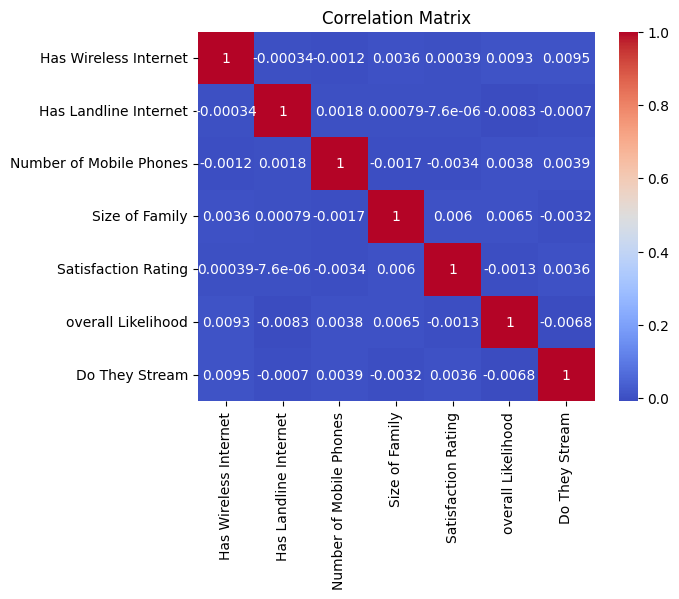

In [16]:
# Calculate correlations
corr = df[['Has Wireless Internet', 'Has Landline Internet', 'Number of Mobile Phones', 'Size of Family', 'Satisfaction Rating', 'overall Likelihood','Do They Stream']].corr()
# Plot heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

##### Correlation Matrix above kind of shows that none of the selected features have strong correlation to others

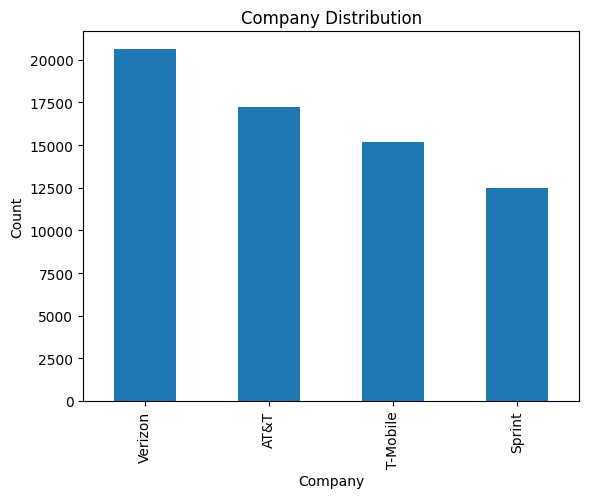

In [17]:
df['Company'].value_counts().plot(kind='bar')
plt.title('Company Distribution')
plt.xlabel('Company')
plt.ylabel('Count')
plt.show()

In [18]:
# Calculate Spearman's correlation
from scipy.stats import spearmanr
correlation, p_value = spearmanr(df['price rating'], df['switched'])
print("Spearman's correlation coefficient:", correlation)
print("P-value:", p_value)

Spearman's correlation coefficient: -0.0017018394851081682
P-value: 0.6629414562038201


##### The above correlations calculaed using Sperarman's correlation so far indicates that there is not strong correlation of fetures

In [19]:
# Calculate Spearman correlation for specified features
selected_features = ['customer service', 'price rating']
correlation_matrix = df[selected_features + ['switched']].corr(method='spearman')

# Display Spearman correlations
spearman_correlations = correlation_matrix['switched'].drop('switched')
print(spearman_correlations)

customer service    0.002934
price rating       -0.001702
Name: switched, dtype: float64


##### Let's try to find the best model for this dataset.

In this section, we chose 3 Models, Linear Regression, Decision Tree

In tryig to find the best Model with best paramerts we will do the followings:

- Using GridSearchCV find the best parameters for each model
- Then for each model determine following scores so we can compare them:
  - Accuracy
  - F1
  - RMSE
  - ROC_AUC

###### Train and Test Data split

Typically we do 30% Test Data and 70% Train Data
But in this case, since the dataset is large, need to increase Test size 60% so the process can complete.

In [20]:
X = df.drop('switched', axis=1)
y = df['switched']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [21]:
scoring = {
    'Accuracy': make_scorer(accuracy_score),
    'F1': make_scorer(f1_score),
    'RMSE': make_scorer(lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred)), greater_is_better=False),
    'ROC_AUC': make_scorer(roc_auc_score, needs_proba=True)
}

In [22]:
# Setup encoder for categorical variables
#categorical_features = ['Company']
encoder = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
], remainder='passthrough')

# Identify categorical and numerical columns
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(include=['number']).columns.tolist()

# Create a ColumnTransformer with OneHotEncoder for categorical data and StandardScaler for numerical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

In [23]:
# Define the pipeline with preprocessor and Logistic Regression
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

# Define parameters grid for Logistic Regression
lr_param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'classifier__solver': ['liblinear', 'lbfgs']  # Solver options
}

# Define scoring dictionary
scoring = {
    'Accuracy': make_scorer(accuracy_score),
    'ROC_AUC': make_scorer(roc_auc_score, needs_proba=True),
    'F1': make_scorer(f1_score),
    'RMSE': make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)
}

# Execute GridSearchCV
lr_grid_search = GridSearchCV(lr_pipeline, lr_param_grid, cv=5, scoring=scoring, refit='ROC_AUC')
lr_grid_search.fit(X_train, y_train)


results_df = pd.DataFrame(columns=['Model', 'Best Params', 'Best ROC_AUC', 'Best F1', 'Best RMSE', 'Best Accuracy'])

lr_results = {
    'Model': 'Logistic Regression',
    'Best Params': str(lr_grid_search.best_params_),
    'Best ROC_AUC': lr_grid_search.cv_results_['mean_test_ROC_AUC'][np.argmax(lr_grid_search.cv_results_['rank_test_ROC_AUC'])],
    'Best F1': lr_grid_search.cv_results_['mean_test_F1'][np.argmax(lr_grid_search.cv_results_['rank_test_F1'])],
    'Best RMSE': -lr_grid_search.cv_results_['mean_test_RMSE'][np.argmax(lr_grid_search.cv_results_['rank_test_RMSE'])],
    'Best Accuracy': lr_grid_search.cv_results_['mean_test_Accuracy'][np.argmax(lr_grid_search.cv_results_['rank_test_Accuracy'])]
}

# Append to the DataFrame
results_df = pd.concat([results_df, pd.DataFrame([lr_results])], ignore_index=True)

results_df

,Model,Best Params,Best ROC_AUC,Best F1,Best RMSE,Best Accuracy
0,Logistic Regression,"{'classifier__C': 0.01, 'classifier__solver': ...",0.503003,0.514437,0.705779,0.501862


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65594 entries, 0 to 68999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Has Wireless Internet    65594 non-null  float64
 1   Has Landline Internet    65594 non-null  float64
 2   Number of Mobile Phones  65594 non-null  float64
 3   Company                  65594 non-null  object 
 4   Size of Family           65594 non-null  float64
 5   Do They Stream           65594 non-null  float64
 6   Satisfaction Rating      65594 non-null  float64
 7   price rating             65594 non-null  float64
 8   speed rating             65594 non-null  float64
 9   coverage rating          65594 non-null  float64
 10  customer service         65594 non-null  float64
 11  overall Likelihood       65594 non-null  float64
 12  switched                 65594 non-null  float64
dtypes: float64(12), object(1)
memory usage: 7.0+ MB


AUC: 0.4960764025905902


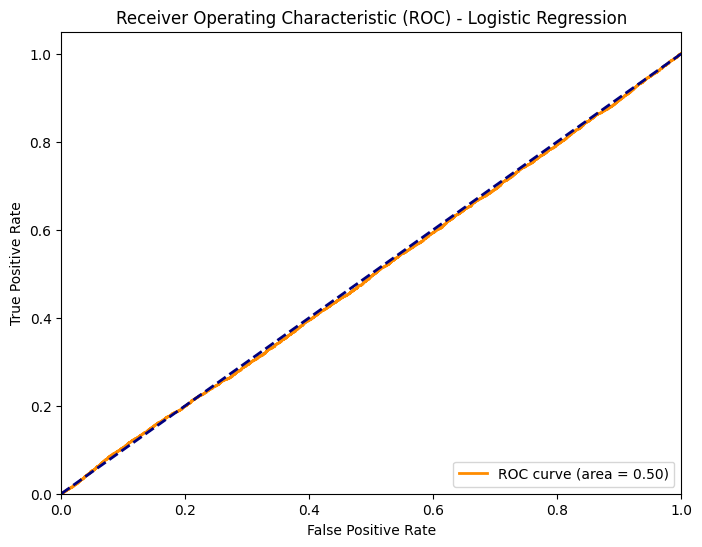

In [25]:

# Create a pipeline with preprocessor and logistic regression
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('log_reg', LogisticRegression())
])

# Parameters for GridSearchCV
param_grid = {
    'log_reg__C': [0.1, 1, 10],
    'log_reg__solver': ['lbfgs']  # Example solver
}

# Setup GridSearchCV
lr_grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc')
lr_grid_search.fit(X_train, y_train)  # Assuming X_train and y_train are defined

# Best model obtained from GridSearchCV
best_lr_model = lr_grid_search.best_estimator_

# Predict probabilities for the positive class
y_probs = best_lr_model.predict_proba(X_test)[:, 1]  # Ensure X_test is preprocessed if not included in pipeline

# Generate ROC curve data
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Output AUC
print("AUC:", roc_auc)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Logistic Regression')
plt.legend(loc="lower right")
plt.show()


In [26]:
# Create a pipeline with the preprocessor and Lasso
lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('lasso', Lasso(max_iter=10000))
])

# Define the parameter grid
lasso_param_grid = {
    'lasso__alpha': [0.001, 0.01, 0.1, 1, 10, 100]
}

# Define custom scoring if necessary, RMSE as an example
scoring = {
    'R2': make_scorer(r2_score),
    'RMSE': make_scorer(lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred)), greater_is_better=False)
}

# Set up GridSearchCV
lasso_grid_search = GridSearchCV(lasso_pipeline, lasso_param_grid, cv=5, scoring=scoring, refit='R2')

# Assuming X_train and y_train are defined and are the features and target variable
lasso_grid_search.fit(X_train, y_train)

# Best model results
print("Best parameters:", lasso_grid_search.best_params_)
print("Best R2 score:", lasso_grid_search.best_score_)
best_index = lasso_grid_search.best_index_
print("Best RMSE:", lasso_grid_search.cv_results_['mean_test_RMSE'][best_index])

Best parameters: {'lasso__alpha': 0.01}
Best R2 score: -0.0001305671622470861
Best RMSE: -0.5000112161983035


Lasso does not seem to be able to effectively capture the relationships between dependent and independent variables

##### Examinng DecisionTree Model

In [27]:
# Decision Tree Pipeline
dt_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier())
])

In [28]:
# Define the parameter grid for Decision Tree
dt_param_grid = {
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 10, 20],
    'classifier__min_samples_leaf': [1, 5, 10]
}

# Set up GridSearchCV with multiple scoring metrics
scoring = {
    'Accuracy': 'accuracy',
    'ROC_AUC': 'roc_auc_ovr',  # For binary/multiclass classification
    'F1': 'f1'
}

# Configure GridSearchCV
grid_search_dt = GridSearchCV(dt_pipeline, dt_param_grid, cv=5, scoring=scoring, refit='ROC_AUC')
grid_search_dt.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Has '
                                                                          'Wireless '
                                                                          'Internet',
                                                                          'Has '
                                                                          'Landline '
                                                                          'Internet',
                                                                          'Number '
                                                                          'of '
                                                                          'Mobile '
                                                                          'Phones',
                                                                          'Size '
                                                                          'of '
                                                                          'Family',
                                                                          'Do '
                                                                          'They '
                                                                          'Stream',
                                                                          'Satisfaction '
                                                                          'Rating',
                                                                          'price '
                                                                          'rating',
                                                                          'speed '
                                                                          'rating',
                                                                          'coverage '
                                                                          'rating',
                                                                          'customer '
                                                                          'service',
                                                                          'overall '
                                                                          'Likelihood']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Company'])])),
                                       ('classifier',
                                        DecisionTreeClassifier())]),
             param_grid={'classifier__max_depth': [None, 10, 20, 30],
                         'classifier__min_samples_leaf': [1, 5, 10],
                         'classifier__min_samples_split': [2, 10, 20]},
             refit='ROC_AUC',
             scoring={'Accuracy': 'accuracy', 'F1': 'f1',
                      'ROC_AUC': 'roc_auc_ovr'})

In [29]:
# Best model results
print("Best parameters:", grid_search_dt.best_params_)
print("Best ROC_AUC:", grid_search_dt.best_score_)
print("Best model scores on each metric:")
for scorer in scoring:
    print(f"{scorer}: {grid_search_dt.cv_results_['mean_test_' + scorer][grid_search_dt.best_index_]}")

Best parameters: {'classifier__max_depth': 30, 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 2}
Best ROC_AUC: 0.5292328695168659
Best model scores on each metric:
Accuracy: 0.5219988894276222
ROC_AUC: 0.5292328695168659
F1: 0.511246263356413


In [30]:
# Assuming grid_search_dt is already fitted with the best model
best_dt_model = grid_search_dt.best_estimator_

# Predict probabilities for the positive class
y_probs = best_dt_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

# Compute ROC curve and ROC area for the model
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

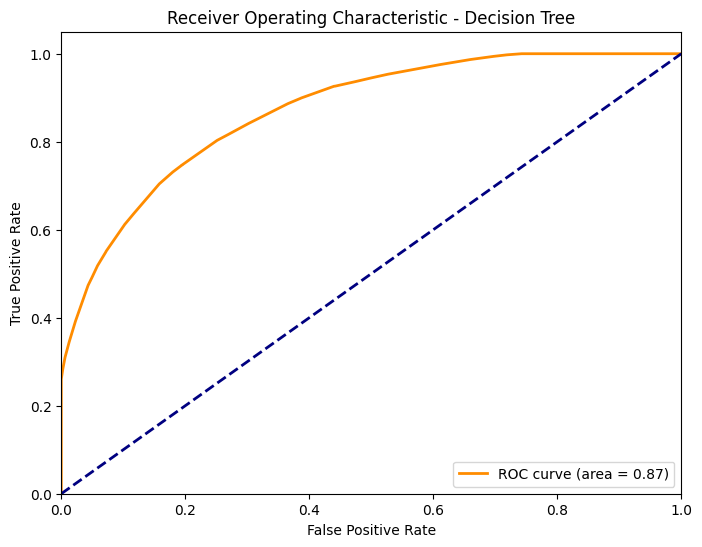

In [31]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Decision Tree')
plt.legend(loc="lower right")
plt.show()

##### Comparing the Models
Comparing the 3 models, Although they all have accuracy in comoon but the Decition Tree seems to be giving a hgh ROC of 0.87 which means this model can distinction better from positive and negative vs the Logistic regresson where ROC was right in the middle.

In [32]:
X = df.drop('switched', axis=1)  # Drops the target column and uses the rest as features
y = df['switched']  # The target variable

In [33]:
df.head()

,Has Wireless Internet,Has Landline Internet,Number of Mobile Phones,Company,Size of Family,Do They Stream,Satisfaction Rating,price rating,speed rating,coverage rating,customer service,overall Likelihood,switched
0,0.0,1.0,2.0,T-Mobile,4.0,0.0,3.0,1.0,2.0,3.0,3.0,2.0,0.0
1,1.0,1.0,5.0,AT&T,7.0,1.0,2.0,2.0,4.0,1.0,2.0,3.0,0.0
2,1.0,1.0,1.0,T-Mobile,1.0,1.0,2.0,2.0,4.0,3.0,1.5,1.0,1.0
4,1.0,1.0,2.0,T-Mobile,2.0,1.0,2.0,2.0,1.0,3.0,1.0,2.0,1.0
5,0.0,1.0,6.0,AT&T,2.0,0.0,3.0,2.5,2.0,3.0,4.0,4.0,0.0


###### Cross Validation of decsion Tree Model

In [34]:
from sklearn.model_selection import cross_val_score, cross_validate

# Create a pipeline

# Get the correct columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  # Applying standard scaling to numerical features
        ('cat', OneHotEncoder(), categorical_features)  # Applying one-hot encoding to categorical features
    ],
    remainder='passthrough'  # Adjust this if there are columns to be left unchanged
)


pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(max_depth=20))
])


# Perform cross-validation
cv_results = cross_validate(pipeline, X, y, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1'])

# Print average scores
print("Average Accuracy: %0.2f" % cv_results['test_accuracy'].mean())
print("Average Precision: %0.2f" % cv_results['test_precision'].mean())
print("Average Recall: %0.2f" % cv_results['test_recall'].mean())
print("Average F1 Score: %0.2f" % cv_results['test_f1'].mean())

Average Accuracy: 0.52
Average Precision: 0.52
Average Recall: 0.51
Average F1 Score: 0.52


In [35]:
pipeline.fit(X, y)

# Get feature importances
importances = pipeline.named_steps['classifier'].feature_importances_


feature_names = list(pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out()) + numerical_features

# Create a DataFrame to view
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Display
print(feature_importance)

                    Feature  Importance
3           Company_Verizon    0.141026
6   Number of Mobile Phones    0.120994
2          Company_T-Mobile    0.110113
8            Do They Stream    0.108009
7            Size of Family    0.094564
10             price rating    0.090133
9       Satisfaction Rating    0.088366
5     Has Landline Internet    0.065246
4     Has Wireless Internet    0.044672
13         customer service    0.029701
11             speed rating    0.028914
12          coverage rating    0.027400
14       overall Likelihood    0.027333
1            Company_Sprint    0.023461
0              Company_AT&T    0.000069


##### Feature Importance based on Decision Tree
Taking the decision tree as the best model, in comparson with other models.
By looking at this data, it appears that we can get the most importance features

Based on the above, the top 3 features customers are looking to switch is company as Verizon.

##### One more Model
Before concluding between the previous models, we try one more to see if it provides better results than previous models
As part of the next one we are running Randon Forest.

Best hyperparameters: {'classifier__bootstrap': True, 'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Best model scores on each metric:
Accuracy: 0.5624269526
ROC_AUC: 0.5936731954
F1: 0.5620708946


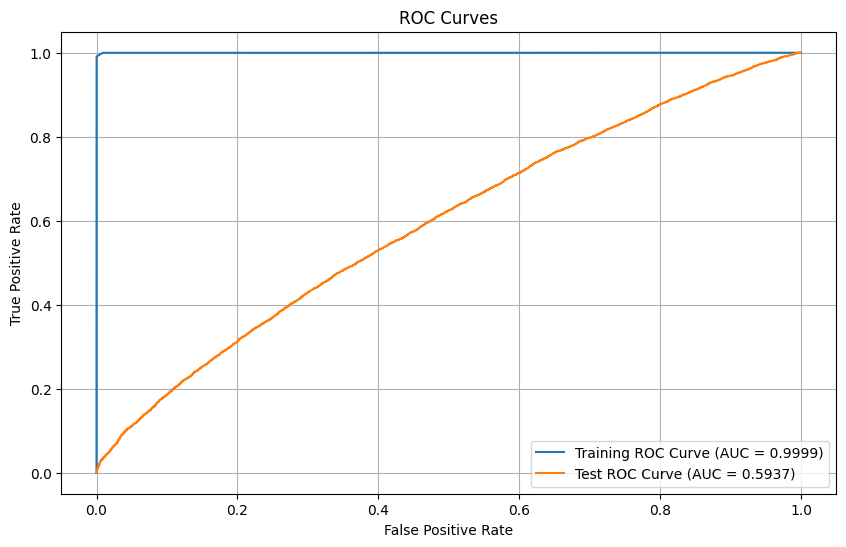

Cross-validation Training Accuracies: [0.56321464 0.55363171 0.55537406 0.55864097 0.5611456 ]
Cross-validation Test Accuracies: [0.52845528 0.54014228 0.53226626 0.53328252 0.53087675]


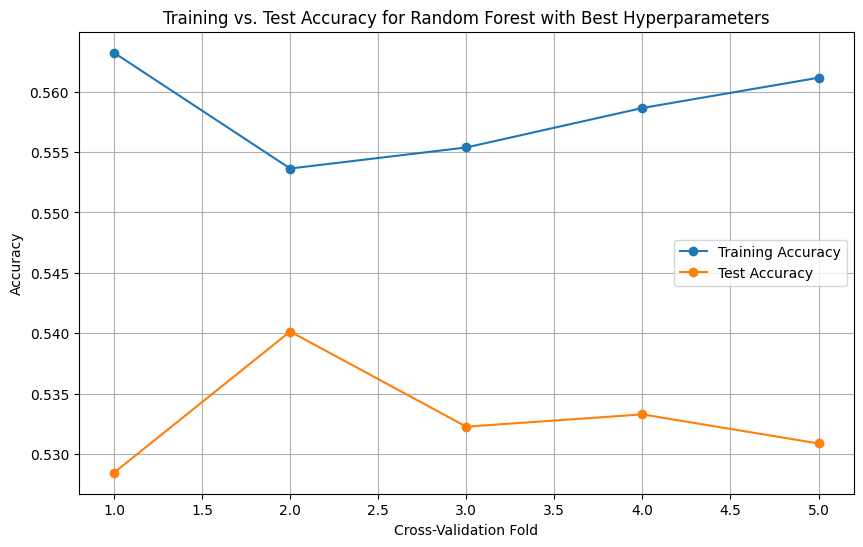

In [36]:


# Separate the features and the target
df = pd.read_csv('drive/MyDrive/project_data/cleaned_up_dataset_2.csv')
X = df.drop(columns=['switched', 'Company'])
y = df['switched']

# Split the data into training and testing sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the pipeline
pipeline_f = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Define the parameter grid
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__bootstrap': [True, False]
}

# Perform GridSearchCV
grid_search = GridSearchCV(pipeline_f, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_

# Best hyperparameters
print(f"Best hyperparameters: {grid_search.best_params_}")

# Evaluate the model on the training set
y_train_pred = best_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_roc_auc = roc_auc_score(y_train, best_model.predict_proba(X_train)[:, 1])
train_f1 = f1_score(y_train, y_train_pred)

# Evaluate the model on the test set
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])
test_f1 = f1_score(y_test, y_test_pred)

# Print the best model scores
print(f"Best model scores on each metric:")
print(f"Accuracy: {test_accuracy:.10f}")
print(f"ROC_AUC: {test_roc_auc:.10f}")
print(f"F1: {test_f1:.10f}")

# Plot ROC curves
train_fpr, train_tpr, _ = roc_curve(y_train, best_model.predict_proba(X_train)[:, 1])
test_fpr, test_tpr, _ = roc_curve(y_test, best_model.predict_proba(X_test)[:, 1])

plt.figure(figsize=(10, 6))
plt.plot(train_fpr, train_tpr, label='Training ROC Curve (AUC = {:.4f})'.format(train_roc_auc))
plt.plot(test_fpr, test_tpr, label='Test ROC Curve (AUC = {:.4f})'.format(test_roc_auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True)
plt.show()

# Perform cross-validation and plot accuracies
train_accuracies = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')
test_accuracies = cross_val_score(best_model, X_test, y_test, cv=5, scoring='accuracy')

print(f"Cross-validation Training Accuracies: {train_accuracies}")
print(f"Cross-validation Test Accuracies: {test_accuracies}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), train_accuracies, label='Training Accuracy', marker='o')
plt.plot(range(1, 6), test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel('Cross-Validation Fold')
plt.ylabel('Accuracy')
plt.title('Training vs. Test Accuracy for Random Forest with Best Hyperparameters')
plt.legend()
plt.grid(True)
plt.show()


##### Feature Importance
Taking the decision tree as the best model, in comparson with other models.
By looking at this data, it appears that we can get the most importance features.


## Running New Syntatic Data against the Decision Tree Model

##### Creating syntathic data for prediction.

In [37]:
num_rows = 10  # For example, create 10 new data points

# Generate random data based on the dataset
np.random.seed(42)
new_data = {
    'Has Wireless Internet': np.random.choice([0.0, 1.0], num_rows),
    'Has Landline Internet': np.random.choice([0.0, 1.0], num_rows),
    'FiOS': np.random.choice([0.0, 1.0], num_rows),
    'Number of Mobile Phones': np.random.randint(1, 5, num_rows),  # Assuming 1-4 phones
    'Company': np.random.choice(['Verizon', 'AT&T', 'Sprint','T-Mobile'], num_rows),
    'Size of Family': np.random.randint(1, 6, num_rows),  # Assuming family sizes of 1-5
    'Do They Stream': np.random.choice([0.0, 1.0], num_rows),
    'Satisfaction Rating': np.random.uniform(1, 5, num_rows),  # Ratings between 1-5
    'price rating': np.random.uniform(1, 5, num_rows),  # Ratings between 1-5
    'speed rating': np.random.uniform(1, 5, num_rows),  # Ratings between 1-5
    'coverage rating': np.random.uniform(1, 5, num_rows),  # Ratings between 1-5
    'customer service': np.random.uniform(1, 5, num_rows),  # Ratings between 1-5
    'overall Likelihood': np.random.uniform(1, 5, num_rows)  # Likelihoods between 1-5
}

new_df = pd.DataFrame(new_data)
new_df


,Has Wireless Internet,Has Landline Internet,FiOS,Number of Mobile Phones,Company,Size of Family,Do They Stream,Satisfaction Rating,price rating,speed rating,coverage rating,customer service,overall Likelihood
0,0.0,0.0,1.0,1,Sprint,3,1.0,3.736932,3.186841,1.180909,1.298203,2.433863,4.548851
1,1.0,0.0,0.0,1,Sprint,4,0.0,2.760610,1.739418,2.301321,4.947548,1.463476,2.888860
2,0.0,0.0,1.0,4,AT&T,4,1.0,1.488153,4.878339,2.554709,4.088979,4.452414,1.478377
3,0.0,0.0,1.0,2,T-Mobile,1,1.0,2.980708,4.100531,2.085396,1.794863,3.493193,3.852979
4,0.0,1.0,1.0,2,T-Mobile,3,1.0,1.137554,4.757996,4.314950,1.022088,2.323592,4.043140
5,1.0,0.0,1.0,1,T-Mobile,5,1.0,4.637282,4.579309,2.427013,4.261846,1.254233,3.245109
6,0.0,1.0,1.0,4,T-Mobile,3,0.0,2.035120,3.391600,2.123738,3.827429,2.243929,4.083869
7,0.0,1.0,1.0,1,Sprint,5,1.0,3.650089,4.687497,3.170784,3.916029,2.300733,2.975182
8,0.0,1.0,1.0,1,AT&T,1,0.0,2.246844,1.353970,1.563697,4.085081,3.918425,3.090931
9,1.0,0.0,1.0,3,AT&T,2,1.0,3.080272,1.783931,4.208788,1.296179,3.550230,2.710164


In [39]:
print("Number of features in new data:", new_df.shape[1])
print("Number of features expected by pipeline:", pipeline.steps[-1][1].n_features_in_)

Number of features in new data: 13
Number of features expected by pipeline: 15


In [ ]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Has Wireless Internet',
                                                   'Has Landline Internet',
                                                   'FiOS',
                                                   'Number of Mobile Phones',
                                                   'Size of Family',
                                                   'Do They Stream',
                                                   'Satisfaction Rating',
                                                   'price rating',
                                                   'speed rating',
                                                   'coverage rating',
                                                   'customer service',
                                                   'overall Likelihood']),
                                                 ('cat', OneHotEncoder(),
                                                  ['Company'])])),
                ('classifier', DecisionTreeClassifier(max_depth=20))])

In [40]:
predictions = pipeline.predict(new_df)
new_df['predictions'] = predictions
new_df

,Has Wireless Internet,Has Landline Internet,FiOS,Number of Mobile Phones,Company,Size of Family,Do They Stream,Satisfaction Rating,price rating,speed rating,coverage rating,customer service,overall Likelihood,predictions
0,0.0,0.0,1.0,1,Sprint,3,1.0,3.736932,3.186841,1.180909,1.298203,2.433863,4.548851,0.0
1,1.0,0.0,0.0,1,Sprint,4,0.0,2.760610,1.739418,2.301321,4.947548,1.463476,2.888860,1.0
2,0.0,0.0,1.0,4,AT&T,4,1.0,1.488153,4.878339,2.554709,4.088979,4.452414,1.478377,1.0
3,0.0,0.0,1.0,2,T-Mobile,1,1.0,2.980708,4.100531,2.085396,1.794863,3.493193,3.852979,0.0
4,0.0,1.0,1.0,2,T-Mobile,3,1.0,1.137554,4.757996,4.314950,1.022088,2.323592,4.043140,0.0
5,1.0,0.0,1.0,1,T-Mobile,5,1.0,4.637282,4.579309,2.427013,4.261846,1.254233,3.245109,0.0
6,0.0,1.0,1.0,4,T-Mobile,3,0.0,2.035120,3.391600,2.123738,3.827429,2.243929,4.083869,1.0
7,0.0,1.0,1.0,1,Sprint,5,1.0,3.650089,4.687497,3.170784,3.916029,2.300733,2.975182,0.0
8,0.0,1.0,1.0,1,AT&T,1,0.0,2.246844,1.353970,1.563697,4.085081,3.918425,3.090931,0.0
9,1.0,0.0,1.0,3,AT&T,2,1.0,3.080272,1.783931,4.208788,1.296179,3.550230,2.710164,0.0
